<a href="https://colab.research.google.com/github/kotatakehara/Self-efficacy/blob/two-dimensions/Two_dimensions_Kendama_change_Class_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### すること
グラフ描写の関数をもっと可変性のあるものにする。（例えば、欲しいグラフは似たようなものが多いから引数を変えるだけで目的のグラフを作れるようにする、グラフの初期化など） ←現在これに着手 \\
makeクラスで作成、showクラスで任意のものを表示かつ初期化 \\
各難易度の試行で、ある成功率に到達しなければ変化しないようにした方がいいのではないか？ \\
list型をndarayに統一して行列の計算を簡易化する(shapeが違うndarrayを結合する方法がわからない) ←現在これに着手 \\
5回ずつぐらいで平均を取れるようにも改変する \\
変化するかどうかや度合いをスイッチのように関数の引数で管理できないか？ \\


---

### 終わったこと
2次元への修正 \\
稲邑教授の実験条件に似るように変更 \\
↑特に試行回数と難易度調整部分 \\
成功時と失敗時の皿の調整度調整方法を変更 \\

## わかったこと
おそらくαとβの関係性において、３種類の場合がありえる \\
1.   α=βの場合：均衡が取れているので一般的な難易度調整のパラメータで良さげな結果が取れている
2.   α>βの場合：成功した時の方が効果が大きいため、他の人よりもやる気があり分散が小さくなる傾向がありそう
3.   α<βの場合：失敗した時の方が効果が大きいため、他の人よりもやる気がなく分散が大きくなる傾向がありそう

### 調整の比率について
α<βの場合、α:β=1:2の場合、何度調整は簡易化:困難化=3:1だと良いくらい \\






In [51]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [29]:
arr = np.empty((0,2))
p = [1,1]
arr = np.append(arr,[p],axis=0)
print(arr)
p = [2,2]
arr = np.append([p],arr,axis=0)
print(arr)
arr = np.delete(arr, 0,axis = 0)
print(arr)

[[1. 1.]]
[[2. 2.]
 [1. 1.]]
[[1. 1.]]


In [52]:
class Kendama():    #学習率、皿の移動割合、難易度調整の割合、難易度の初期値を格納
  def __init__(self, get_times): #get_timesはけん玉の総試行回数
    # self.alpha = alpha    #学習率
    # self.beta = beta    #学習率
    # self.a = a    #皿の移動割合
    # self.rt = rt    #難易度調整の割合
    # self.success_rate = success_rate #難易度調整を行う際の成功率の指標
    # self.fail_rate = fail_rate #難易度調整を行う際の失敗率の指標
    mu = np.array([0, 0])
    sigma = np.array([[1, 0], [0, 1]])
    # 2次元正規乱数をけん玉の総試行回数分生成(可能なら独立させて、データを持ち続けるか、リセットを任意にできるようにしたい)
    self.B = np.random.multivariate_normal(mu, sigma, size=get_times)  #けん玉の落下データを格納する配列（locは平均、scaleは標準偏差、sizeは導かれる値の数）つまり各試行時のけん玉の落下位置

  def Ajustment(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment): #難易度を調整した場合（半径を小さくするのみ）の結果を表す関数
    dispersion = np.array([[1**2, 1**2, 0]])    #被験者のやる気を表す分散を格納する配列
    p = np.array([[0,0]])       #皿のガウス分布の平均値を格納する配列
    # success_rate = 0.66 #難易度調整を行う際の成功率の指標
    # fail_rate = 0.66 #難易度調整を行う際の失敗率の指標
    success = 0    #成功回数を表す変数
    trial = 0       #試行回数を表す変数
    x = np.array([])  #試行回数を格納
    R = np.array([])
    srate = np.array([0])
    success = 0
    Abs_degree_failure = np.array([0])
    R = np.append(R, r)
    for i in range(len(self.B)):
      trial += 1
      x = np.append(x, i)
      R = np.append(R, r)
      mu = np.array([p[i][0], p[i][1]])   #平均
      sigma = np.array([[dispersion[i][0], dispersion[i][2]],[dispersion[i][2], dispersion[i][1]]])   #共分散行列
      D = np.random.multivariate_normal(mu, sigma, size=1) #皿の位置を表す変数
      D = D[0] #1次元の配列ができているので取り出す作業
      abs_degree_failure = abs(np.sqrt((self.B[i][0] - D[0])**2+(self.B[i][1] - D[1])**2)) #皿の中心と落下位置の差（絶対値）
      # if abs_degree_failure <= 0:
      #    abs_degree_failure = 0
      Abs_degree_failure = np.append(Abs_degree_failure, abs_degree_failure)
      if (self.B[i][0]-D[0])**2+(self.B[i][1]-D[1])**2 <= r**2:     #成功した時の分散の変化
        p = np.append(p, [D], axis=0)
        dispersion = np.append(dispersion, [dispersion[i] / alpha], axis=0)
        success += 1
        if ajustment:  #Trueなら調整ありなため、半径に対して調整を行う

          r = r / ganma #成功した時の難易度調整

          #  if r < 0.1:    #半径が０.1未満にならないようにするための処置
          #    r = 0.1
      else:       #失敗した時の分散の変化
        if ajustment:
          r = r * ganma
          #r = (r + max(0,(abs_degree_failure-r))) * ganma   #失敗した時の難易度調整※いらない場合はコメントアウトさせる
          #  if r > 3.1:    #半径が０.1未満にならないようにするための処置
          #    r = 3.1
        p = np.append(p, [self.B[i]], axis=0)
        dispersion = np.append(dispersion, [dispersion[i] * beta], axis=0)
      srate = np.append(srate, (success/(i+1))*100)
    x = np.append(x, len(self.B))
    #以下のコードは最初に入れた初期値を削除するコード
    x = np.delete(x, 0)
    p = np.delete(p, 0, axis=0)
    dispersion = np.delete(dispersion, 0, axis=0)
    R = np.delete(R, 0)
    Abs_degree_failure = np.delete(Abs_degree_failure, 0)
    srate = np.delete(srate, 0)
    return x,p,dispersion,R,Abs_degree_failure,srate



In [53]:
#A_min_listの要素数は[1or10,5,201]
class kendama(Kendama):
  def __init__(self, get_times):
    super().__init__(get_times)

  def make_ajustment_from_max_average(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment):
    # 難しい方から調整した場合の分散のデータを格納
    A_min_list =  np.empty((0,7,get_times))
    A_min_average_list = np.empty((0,7,get_times))
    for i in range(1): #forのループ回数は一旦1回にしている
        A_x, A_p, A_dispersion, R, Abs_degree_failure, srate = self.Ajustment(r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment)
        A_min_list = np.append(A_min_list, [[A_x, A_p[:,0], A_p[:,1], A_dispersion[:,0], R, Abs_degree_failure, srate]], axis=0)

    # self.A_min_list_np = np.array(self.A_min_list)
    A_min_average_list = np.append(A_min_average_list, np.mean(A_min_list, axis=0), axis=0)
    return A_min_average_list

  def show_ajustment_from_max_average(self, A_min_average_list):

    # サブプロットの設定
    fig, axs = plt.subplots(3, len(A_min_average_list), figsize=(16, 2 * 3), sharey="row")

    # グラフのプロット
    for i, (A_x_average, A_p_average_x, A_p_average_y, A_dispersion_average_x, R_average, Abs_degree_failure_average, srate) in enumerate(A_min_average_list):
        axs[0, i].plot(A_x_average, Abs_degree_failure_average, color='r')
        #axs[1, i].plot(A_x_average, [item[0] for item in A_dispersion_average], color='b')
        axs[1, i].plot(A_x_average, srate, color='b')
        axs[2, i].plot(A_x_average, R_average, color='g')
        axs[0, 1].set_ylim(0,10)
        axs[1, 1].set_ylim(0,10)
        # axs[0, i].set_title(f"mean (Trial {i+1})")
        # axs[1, i].set_title(f"dispersion (Trial {i+1})")
        # axs[2, i].set_title(f"r (Trial {i+1})")

    for ax in axs.flat:
        ax.set_xlabel("Number of trials")
    axs[1, 0].set_ylabel('σ^2')
    plt.tight_layout()
    plt.show()

  def show_ajustment_from_max_average_integration(self, A_min_average_list): #複数のグラフを重ねて表示させるための関数
    for i, (A_x_average, A_p_average_x, A_p_average_y, A_dispersion_average_x, R_average, Abs_degree_failure_average, srate) in enumerate(A_min_average_list):
        plt.plot(A_x_average, A_dispersion_average_x)
    plt.xlabel("Number of trials")
    plt.ylabel("σ^2")
    plt.tight_layout()
    plt.savefig(f"difference of change.png")
    files.download(f'difference of change.png')
    plt.show()

  def make_ajustment_from_max(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment):
    # データの格納
    A_min_list = np.empty((0, 7, get_times))

    for _ in range(5):
        A_x, A_p, A_dispersion, R, Abs_degree_failure, srate = self.Ajustment(r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment)
        A_min_list = np.append(A_min_list, [[A_x, A_p[:,0], A_p[:,1], A_dispersion[:,0], R, Abs_degree_failure, srate]], axis=0)
    return A_min_list

  def show_ajustment_from_max(self, A_min_list):
    # プロットの設定
    titles = ["mean", "Success rate(%)", "dispersion", "r"]
    colors = ['r', 'orange', 'b', 'g']
    ylabels = ['degree failure', 'Success rate(%)', 'σ_X^2', 'r']

    fig, axs = plt.subplots(4, len(A_min_list), figsize=(16, 8), sharey='row')
    #グラフの描写部分
    for i, (A_x, A_p_x, A_p_y, A_dispersion_x, R, Abs_degree_failure, srate) in enumerate(A_min_list):
        data = [Abs_degree_failure, srate, A_dispersion_x, R]
        for j in range(4):
            axs[j, i].plot(A_x, data[j], color=colors[j])
            axs[j, i].set_title(f"{titles[j]} (Trial {i+1})")
            axs[j, i].set_xlabel("Number of trials")
            if i == 0:
                axs[j, i].set_ylabel(ylabels[j])

    plt.tight_layout()
    plt.show()

  #ganmaなどを変更した際のグラフの描写関数(ganmaなどの変化するパラメータの引数を配列にすればもっと簡易的にできそう)
  def make_ajustment_from_max_graph(self, r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment):
    # 難しい方から調整した場合の分散のデータを格納
    A_min_list = np.empty((0,7,get_times))
    for i in range(1): #forのループ回数は一旦1回にしている
        A_x, A_p, A_dispersion, R, Abs_degree_failure,srate = self.Ajustment(r, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment)
        A_min_list = np.append(A_min_list, [[A_x, A_p[:,0], A_p[:,1], A_dispersion[:,0], R, Abs_degree_failure, srate]], axis=0)

    return A_min_list


  def show_ajustment_from_max_graph(self, n, metric, A_matrix):  # metric: 'srate', 'abs', 'dispersion', or 'R'
    A_min_list = A_matrix[n:n+4]
    #グラフの設定を辞書行列で表現している
    colors = {
        'srate': 'orange',
        'abs': 'r',
        'dispersion': 'b',
        'R': 'g'
    }
    ylabel = {
        'srate': 'Success rate(%)',
        'abs': 'Degree failure',
        'dispersion': 'σ_X^2,σ_Y^2',
        'R': 'Radius'
    }
    ylim = {
        'srate': None,
        'abs': (0, 3),
        'dispersion': (0, 5),
        'R': (0, 5)
    }

    # サブプロットの設定
    fig, axs = plt.subplots(1, len(A_min_list), figsize=(16, 2 * 1), sharey="row")

    # グラフのプロット
    for i, (A_x_average, A_p_average_x, A_p_average_y, A_dispersion_average_x, R_average, Abs_degree_failure_average, srate) in enumerate(A_min_list):
        if metric == 'srate':
            axs[i].plot(A_x_average, srate, color=colors[metric])
        elif metric == 'abs':
            axs[i].plot(A_x_average, Abs_degree_failure_average, color=colors[metric])
        elif metric == 'dispersion':
            axs[i].plot(A_x_average, A_dispersion_average_x, color=colors[metric])
        elif metric == 'R':
            axs[i].plot(A_x_average, R_average, color=colors[metric])

    for ax in axs.flat:
        ax.set_xlabel("Number of trials(times)")
        ax.set_ylabel(ylabel[metric])
        if ylim[metric]:
            ax.set_ylim(*ylim[metric])

    plt.tight_layout()
    plt.show()
    # 配列の初期化
    self.A_min_average_list = np.empty((0, 7, get_times))


  def show_Comparison(self, n, metric, A_matrix):  # metric: 'srate', 'abs', 'dispersion', or 'R'
      A_min_list = A_matrix[n:n+4]
      colors = ['b', 'g', 'r', 'orange']  # サイクルごとの色のリスト
      ylabel = {
          'srate': 'Success rate',
          'abs': 'Abs degree of failure',
          'dispersion': 'Dispersion',
          'R': 'R value'
      }
      ylim = {
          'srate': None,
          'abs': (0, 5),
          'dispersion': (0, 5),
          'R': (0, 5)
      }

      # グラフのプロット
      for i, (A_x_average, A_p_average_x, A_p_average_y, A_dispersion_average_x, R_average, Abs_degree_failure_average, srate) in enumerate(A_min_list):
          if metric == 'srate':
              plt.plot(A_x_average, srate, colors[i])
          elif metric == 'abs':
              plt.plot(A_x_average, Abs_degree_failure_average, colors[i])
          elif metric == 'dispersion':
              plt.plot(A_x_average, A_dispersion_average_x, colors[i])
          elif metric == 'R':
              plt.plot(A_x_average, R_average, colors[i])

      plt.xlabel("Number of trials")
      plt.ylabel(ylabel[metric])
      if ylim[metric]:
          plt.ylim(*ylim[metric])
      plt.tight_layout()

      plt.tight_layout()
      plt.show()


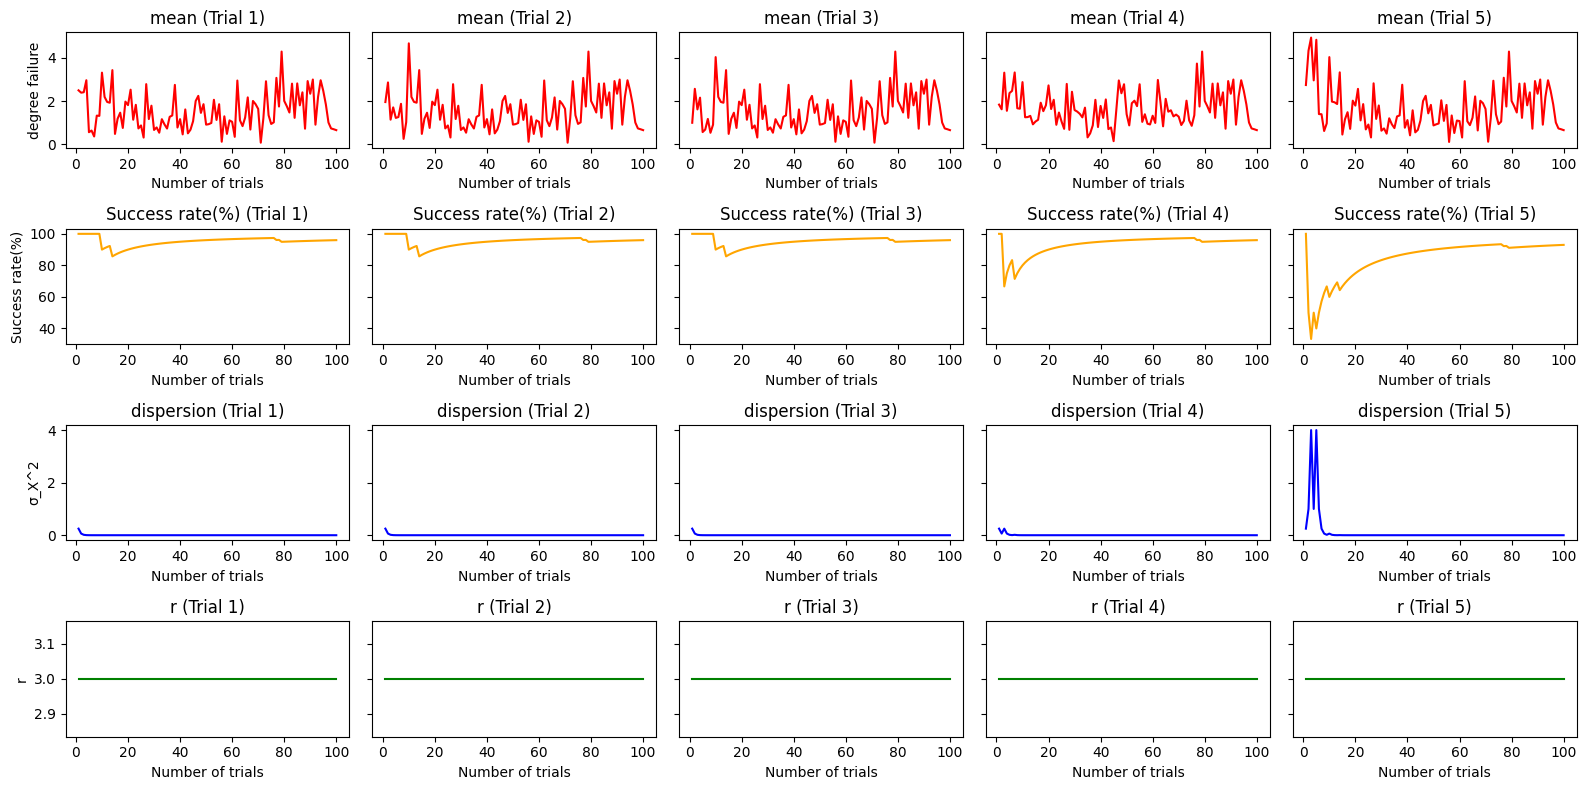

In [55]:
alpha = 4       #成功した場合のやる気の変化量を表す変数
beta = 4   #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 1.5
trial_times = 10
get_times = 100
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
ajustment = False #調節を行うかどうかの判定
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)
Answer_list = kendama_change.make_ajustment_from_max(3.0, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment)
kendama_change.show_ajustment_from_max(Answer_list)

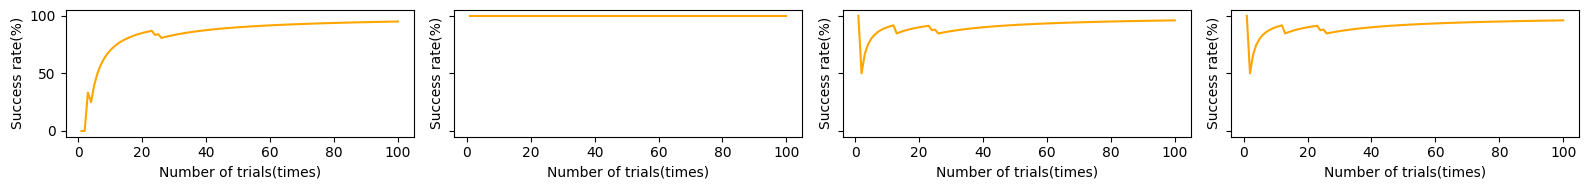

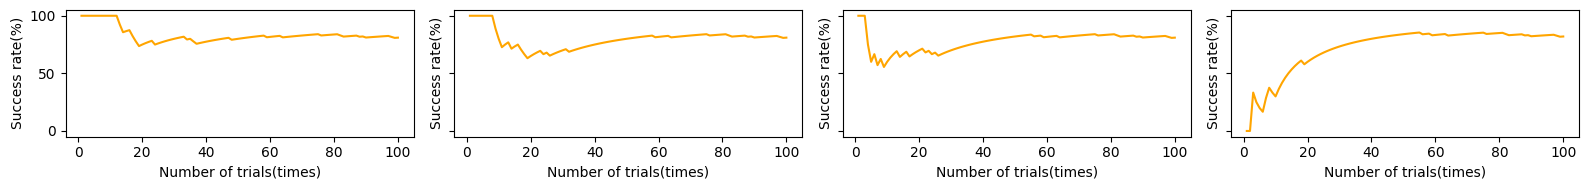

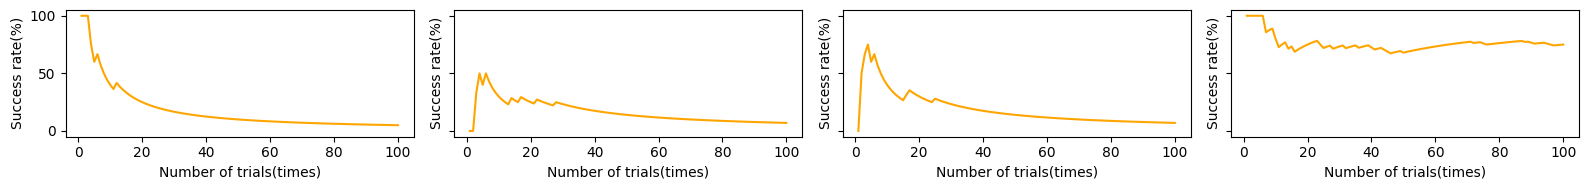

(12, 7, 100)


In [63]:
get_times = 100
kendama_change = kendama(get_times)
A_matrix = np.empty((0,7,get_times))
for i in range(1,5):
  ganma = 1+i*0.1
  Answer_list = kendama_change.make_ajustment_from_max_graph(3.0, trial_times, ganma, 1.3, 1.1, a, success_rate, fail_rate, ajustment)
  A_matrix = np.append(A_matrix, [Answer_list[0]], axis=0)
kendama_change.show_ajustment_from_max_graph(0, "srate", A_matrix)
for i in range(1,5):
  ganma = 1+i*0.1
  Answer_list = kendama_change.make_ajustment_from_max_graph(3.0, trial_times, ganma, 1.2, 1.2, a, success_rate, fail_rate, ajustment)
  A_matrix = np.append(A_matrix, [Answer_list[0]], axis=0)
kendama_change.show_ajustment_from_max_graph(4, "srate", A_matrix)
for i in range(1,5):
  ganma = 1+i*0.1
  Answer_list = kendama_change.make_ajustment_from_max_graph(3.0, trial_times, ganma, 1.1, 1.3, a, success_rate, fail_rate, ajustment)
  A_matrix = np.append(A_matrix, [Answer_list[0]], axis=0)
kendama_change.show_ajustment_from_max_graph(8, "srate", A_matrix)
print(A_matrix.shape)

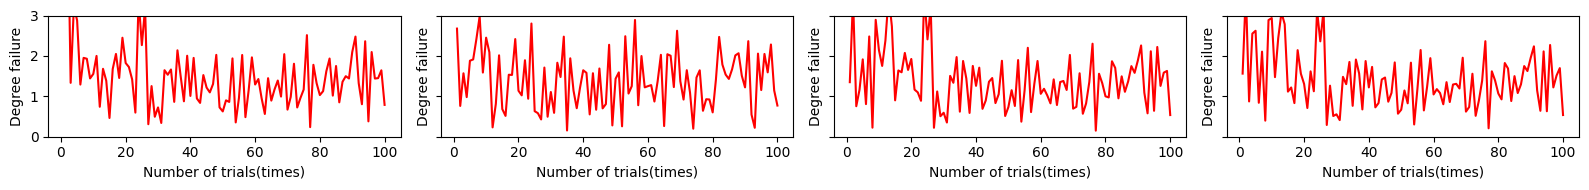

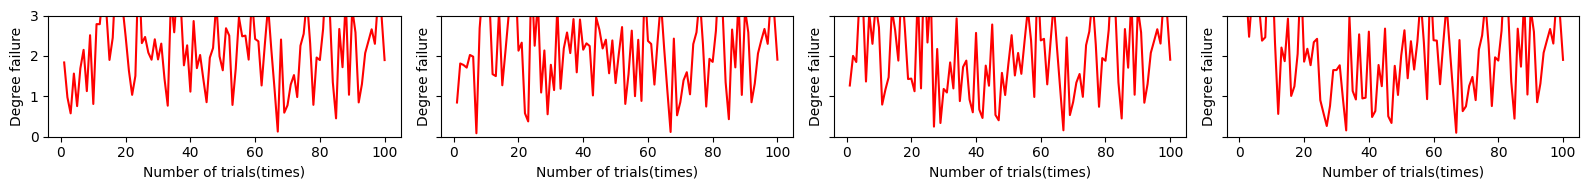

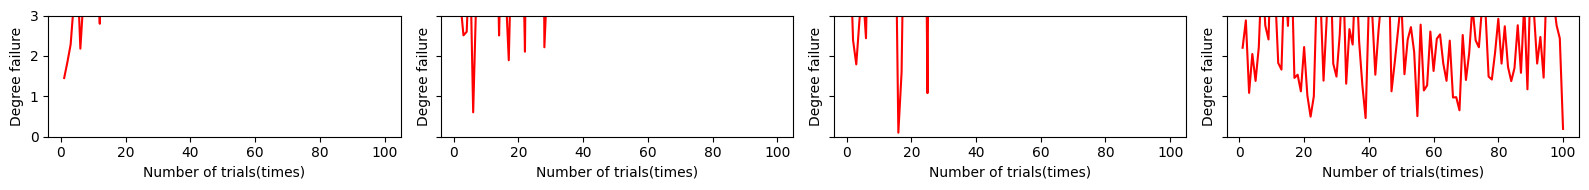

In [64]:
for i in range(0,12,4):
  kendama_change.show_ajustment_from_max_graph(i, "abs", A_matrix)

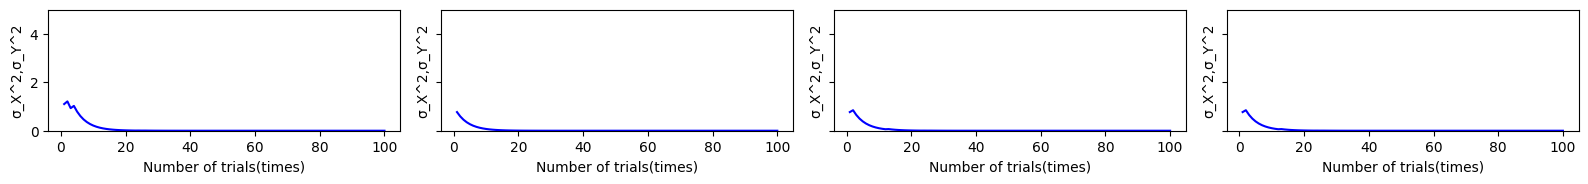

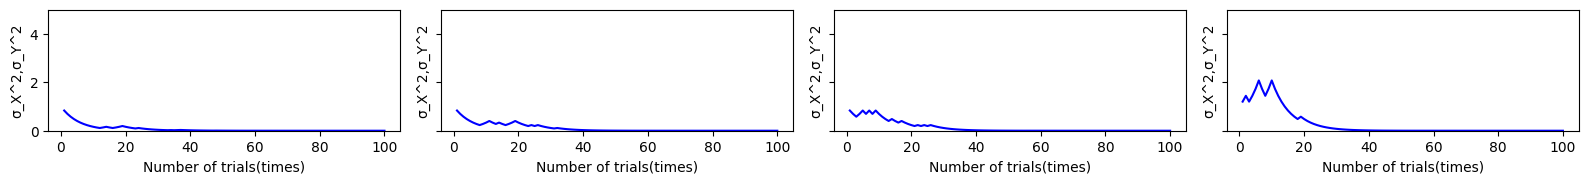

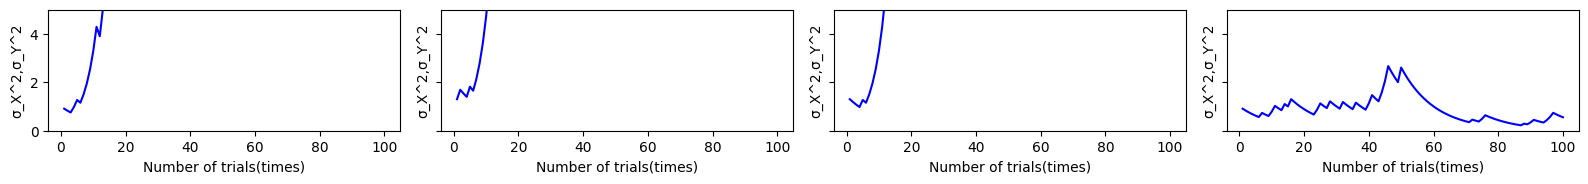

In [65]:
for i in range(0,12,4):
  kendama_change.show_ajustment_from_max_graph(i, "dispersion", A_matrix)

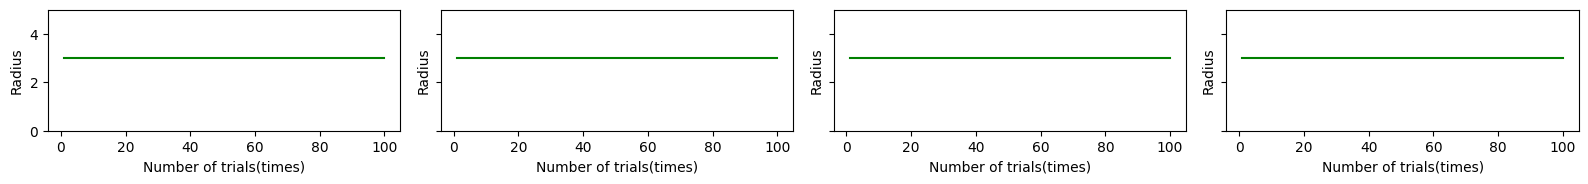

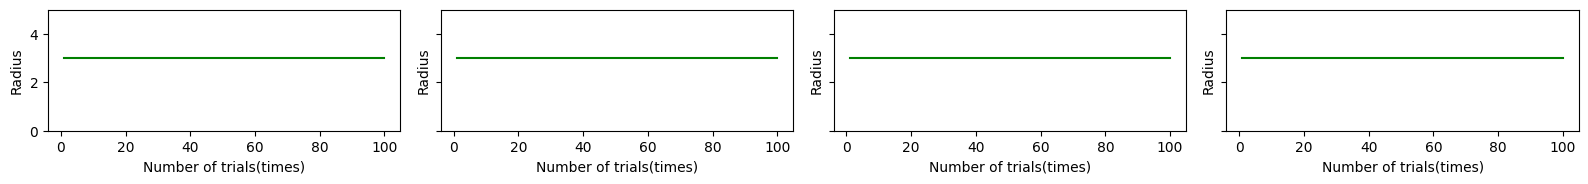

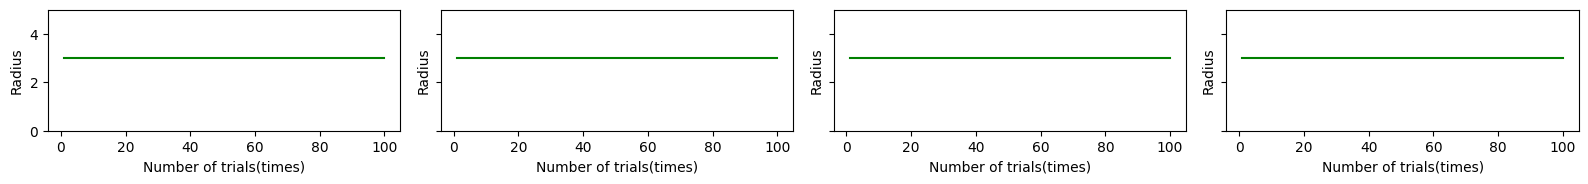

In [66]:
for i in range(0,12,4):
  kendama_change.show_ajustment_from_max_graph(i, "R", A_matrix)

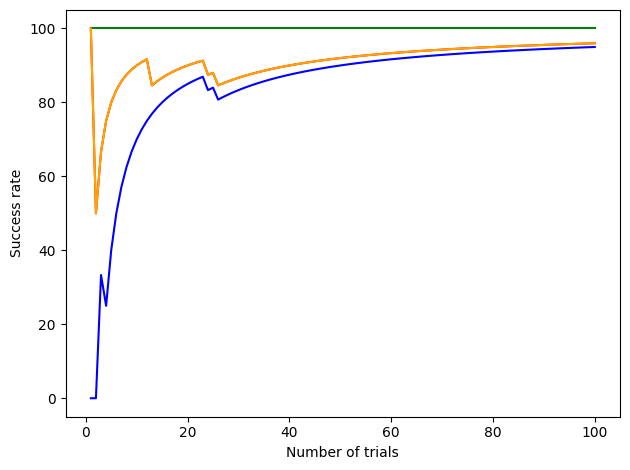

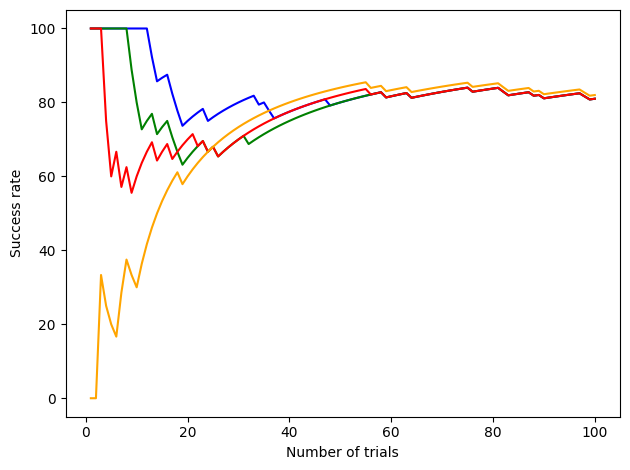

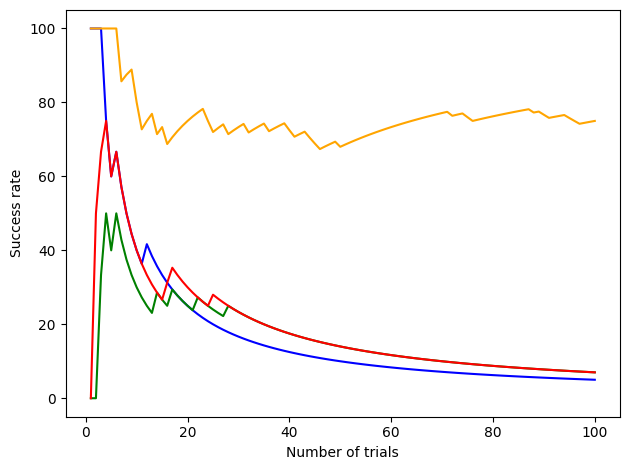

In [67]:
for i in range(0,12,4):
  kendama_change.show_Comparison(i, "srate", A_matrix)

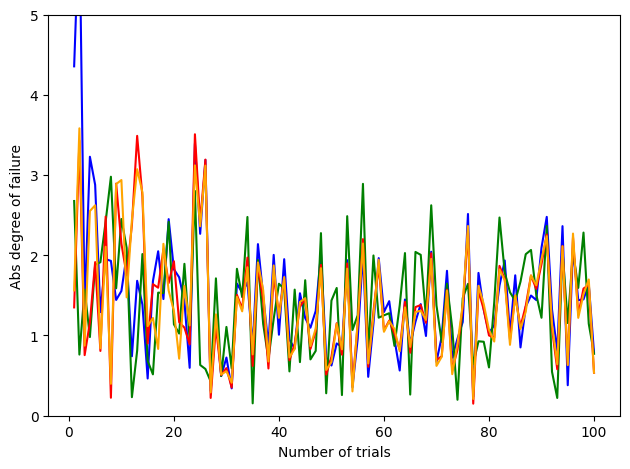

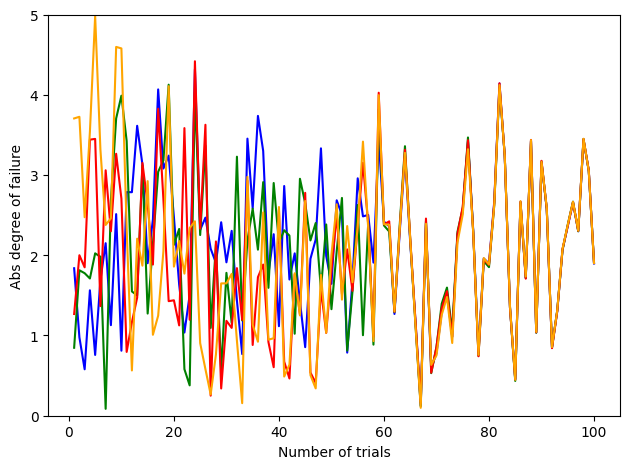

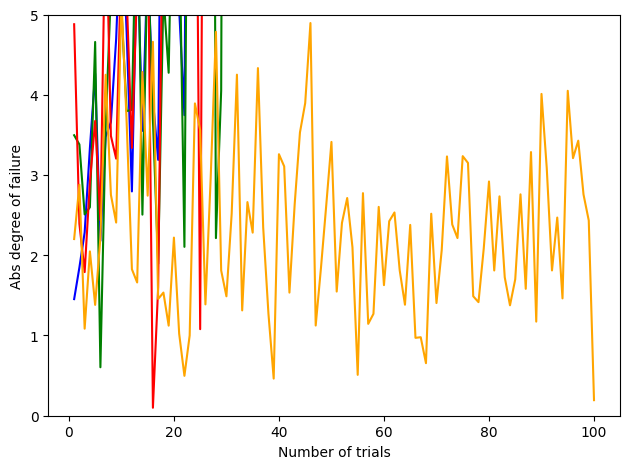

In [68]:
for i in range(0,12,4):
  kendama_change.show_Comparison(i, "abs", A_matrix)

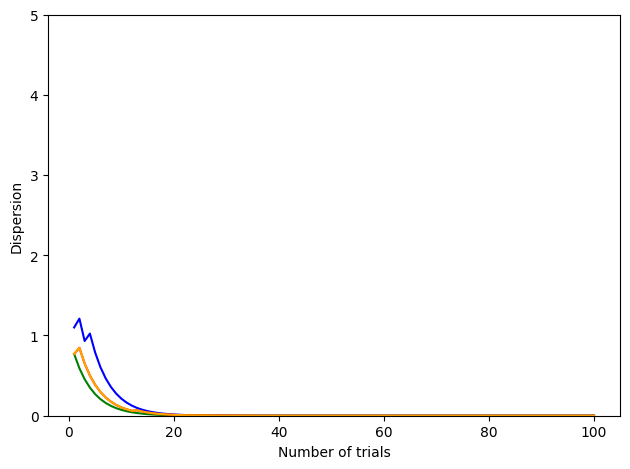

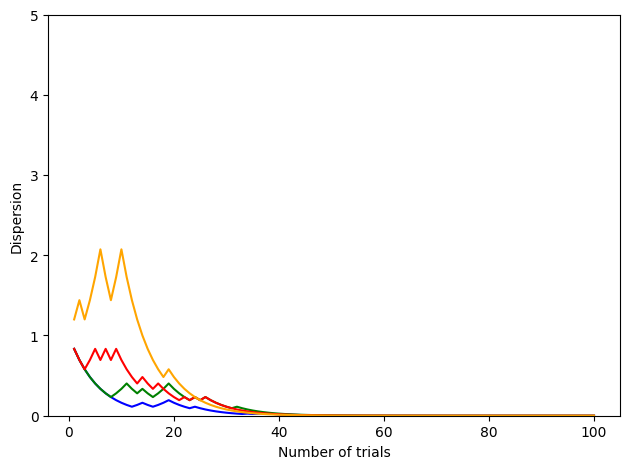

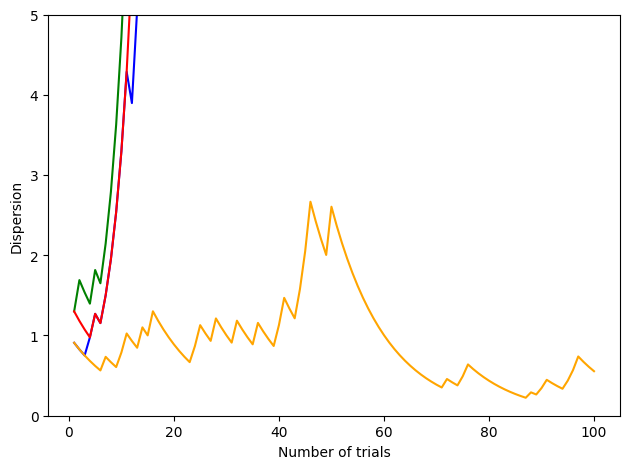

In [69]:
for i in range(0,12,4):
  kendama_change.show_Comparison(i, "dispersion", A_matrix)

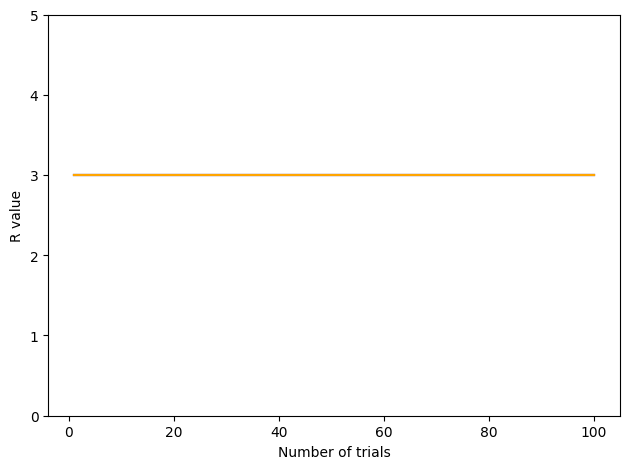

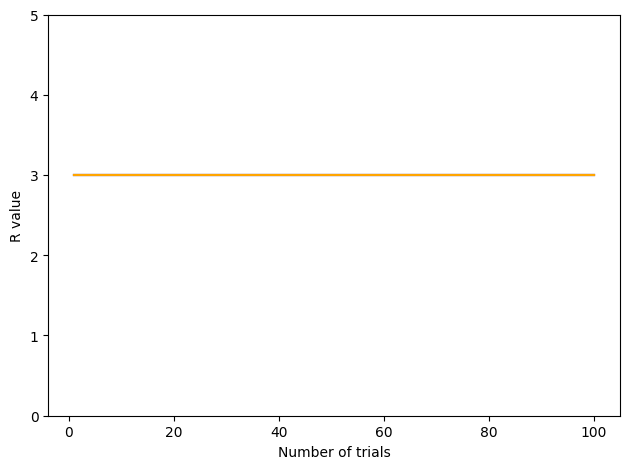

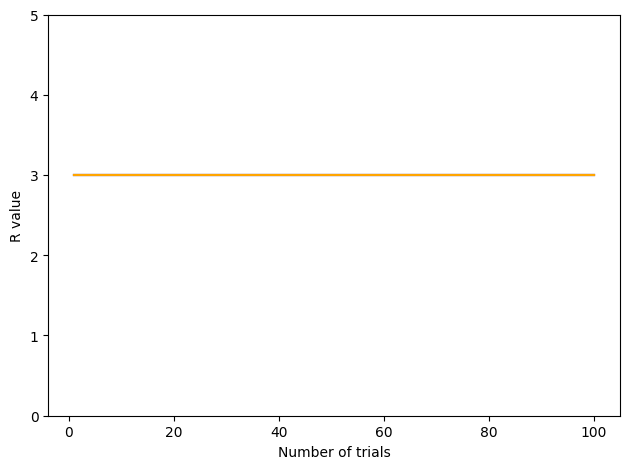

In [70]:
for i in range(0,12,4):
  kendama_change.show_Comparison(i, "R", A_matrix)

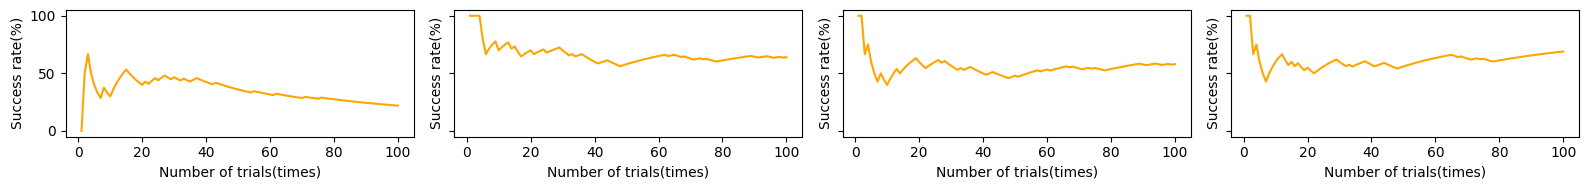

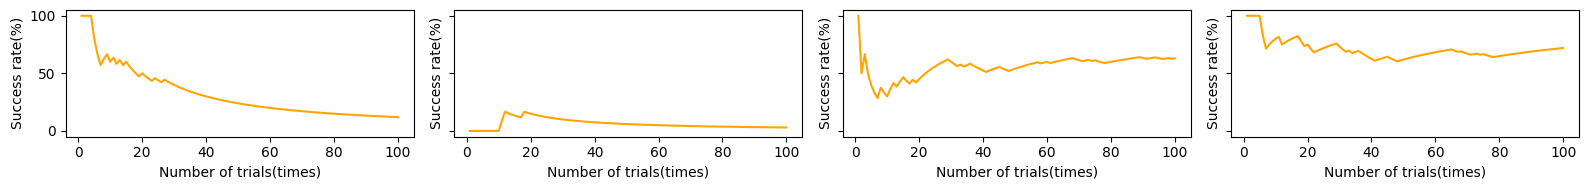

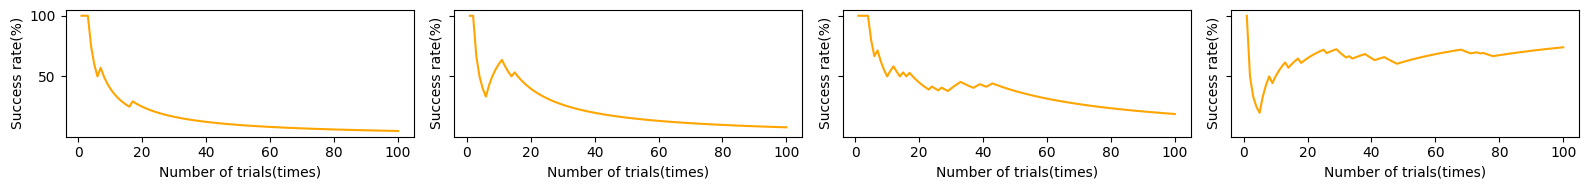

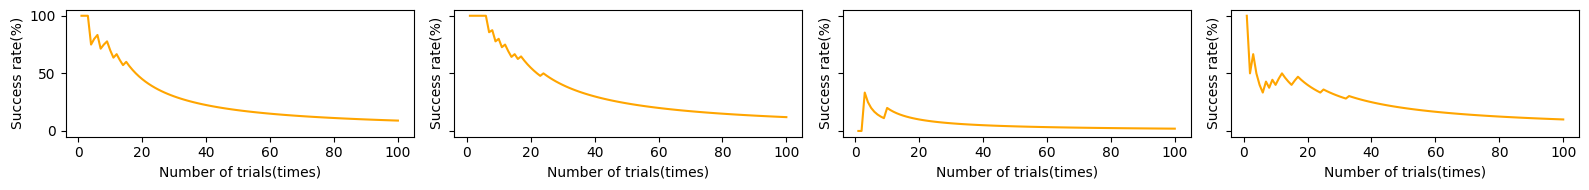

In [73]:
get_times = 100
kendama_change = kendama(get_times)
ganma = 1.1
A_matrix = np.empty((0,7,get_times))
for i in range(1,5):
  beta = 1+i*0.1
  for j in range(1,5):
    alpha = 1+j*0.1
    Answer_list = kendama_change.make_ajustment_from_max_graph(2.0, trial_times, ganma, alpha, beta, a, success_rate, fail_rate, ajustment)
    A_matrix = np.append(A_matrix, [Answer_list[0]], axis=0)
  kendama_change.show_ajustment_from_max_graph((i-1)*j, "srate", A_matrix)

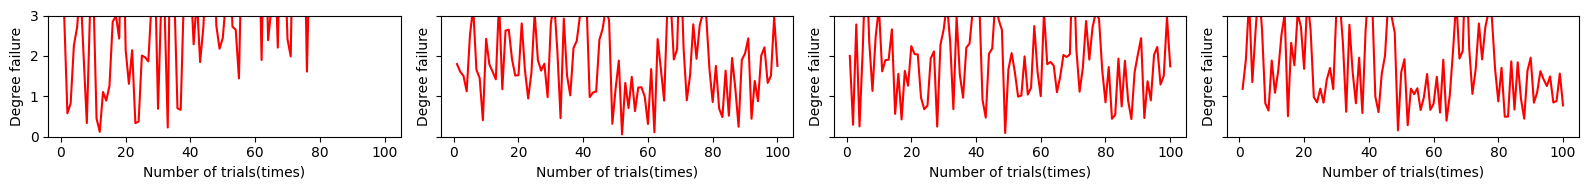

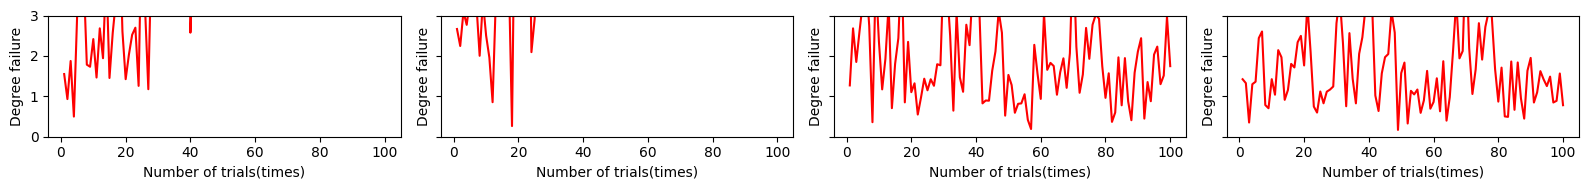

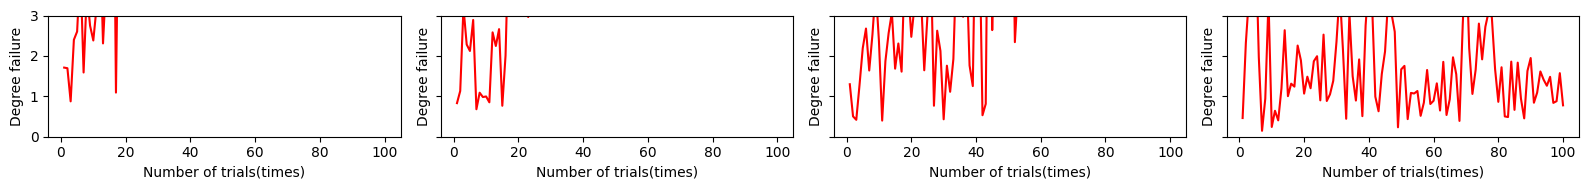

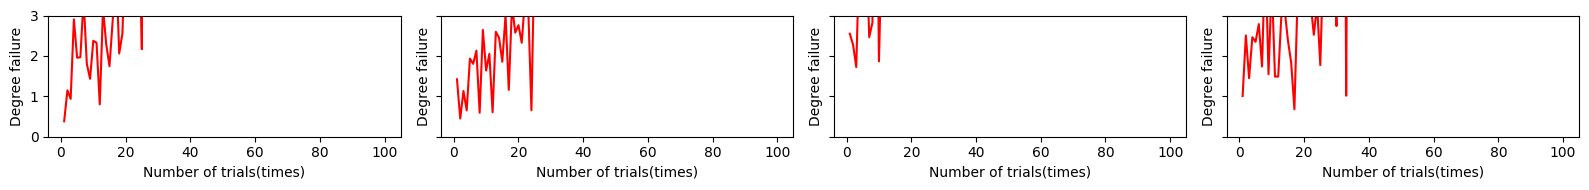

In [75]:
for i in range(0,16,4):
  kendama_change.show_ajustment_from_max_graph(i, "abs", A_matrix)

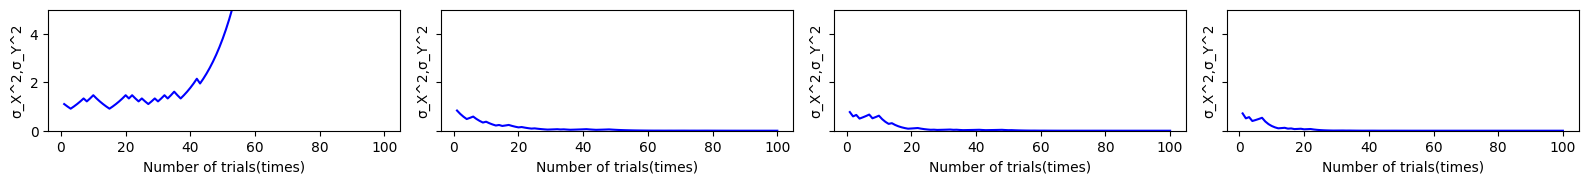

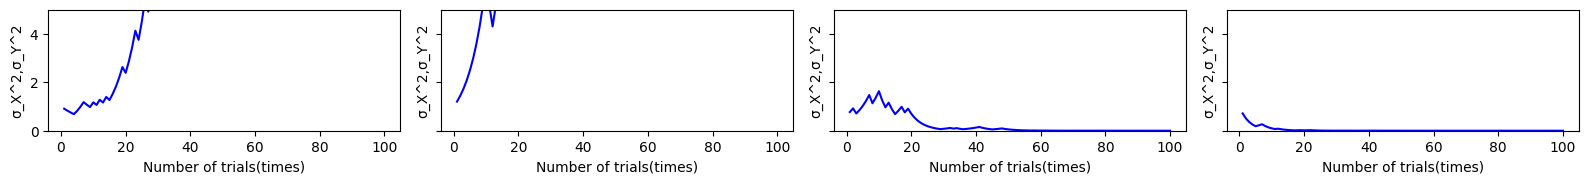

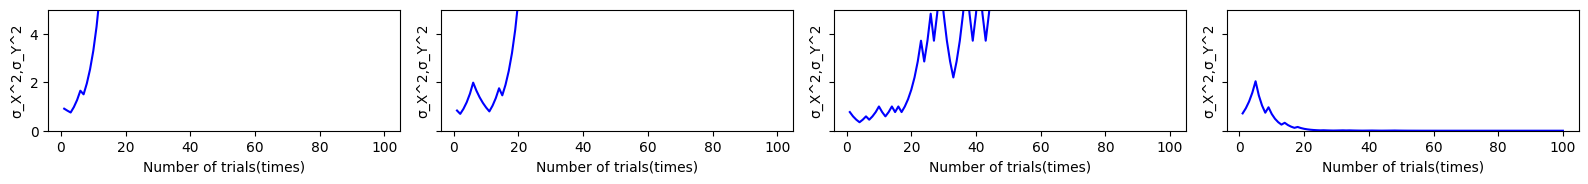

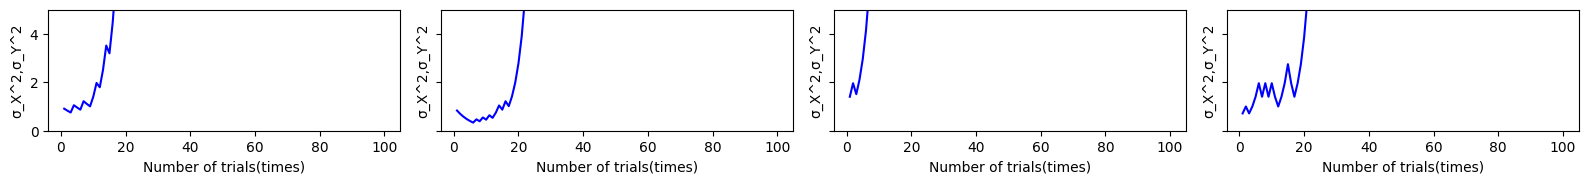

In [76]:
for i in range(0,16,4):
  kendama_change.show_ajustment_from_max_graph(i, "dispersion", A_matrix)

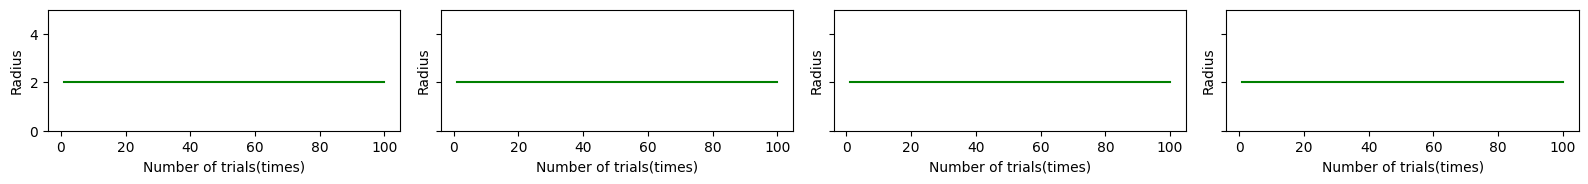

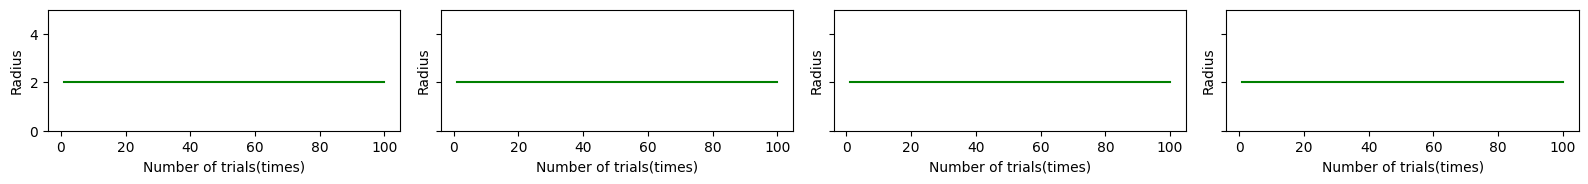

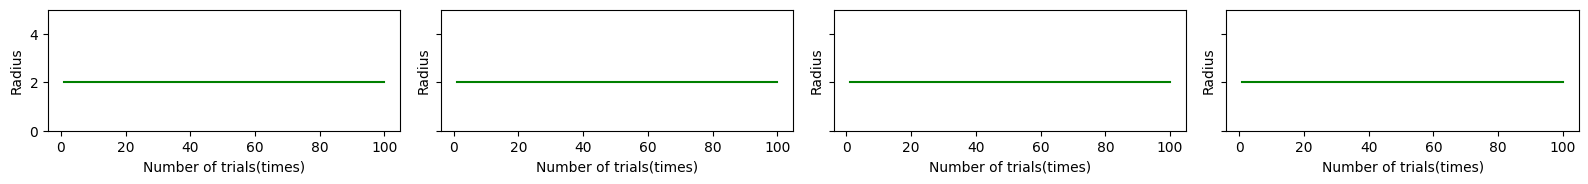

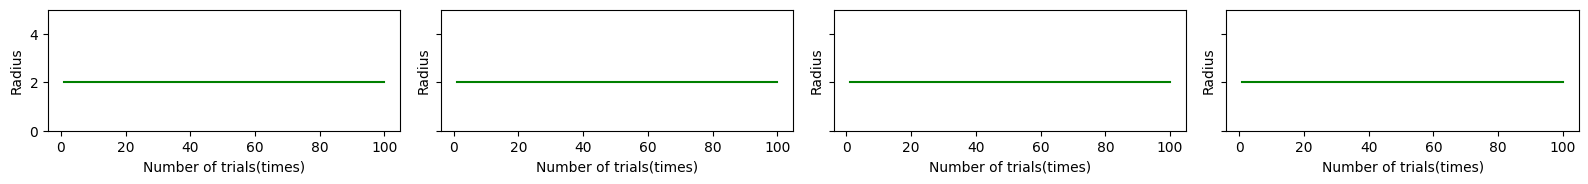

In [77]:
for i in range(0,16,4):
  kendama_change.show_ajustment_from_max_graph(i, "R", A_matrix)

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

In [ ]:
for i in range(1,6):
  beta = i * 0.1
  for j in range(1,6):
    alpha = j * 0.1
    kendama_change.make_ajustment_from_max_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
  kendama_change.show_ajustment_from_min_average()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (1, 6, 31) + inhomogeneous part.

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

In [ ]:
for i in range(1,11):
  a = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
rt = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

In [ ]:
beta = 0.2
alpha = 0.1
ganma = 0.5

kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 10
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
kendama_change.show_Comparison(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)

In [ ]:
kendama_change.show_all("trial_times = 10")

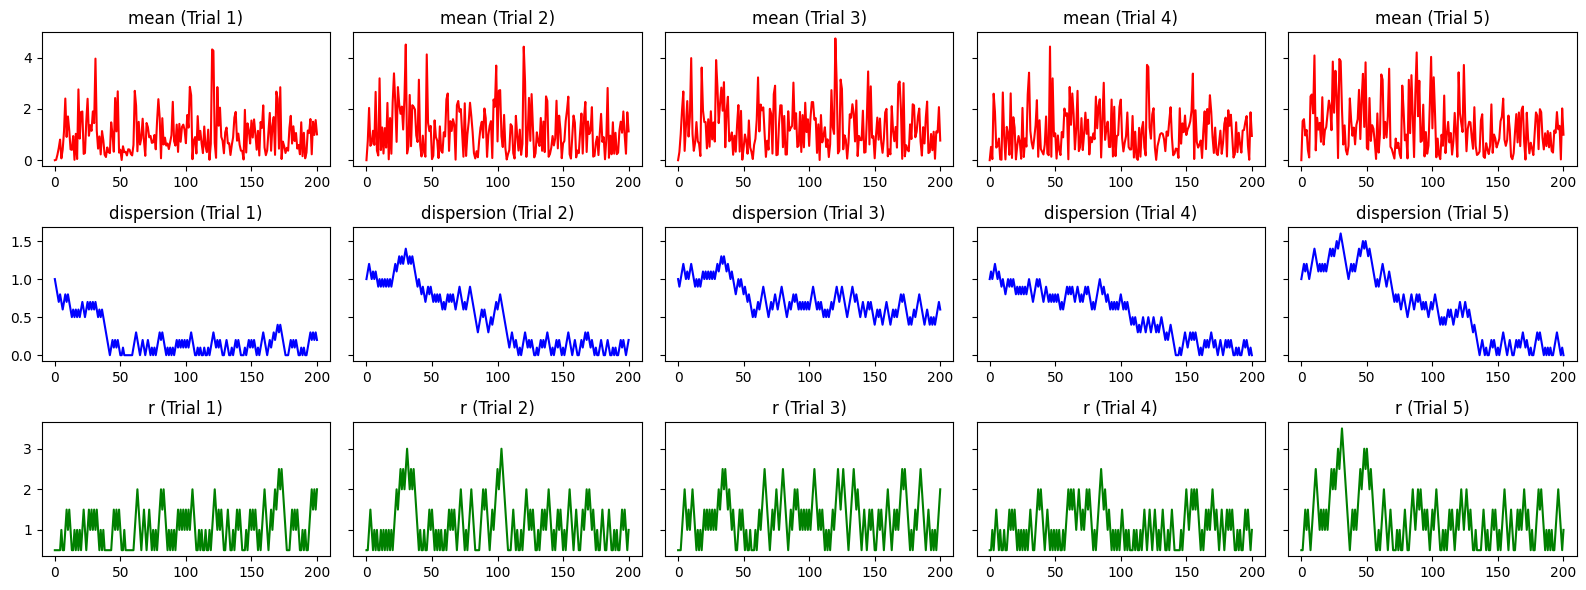

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標
kendama_change = kendama(get_times)
# kendama_change.show_Non(1)

kendama_change.show_ajustment_from_min(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)

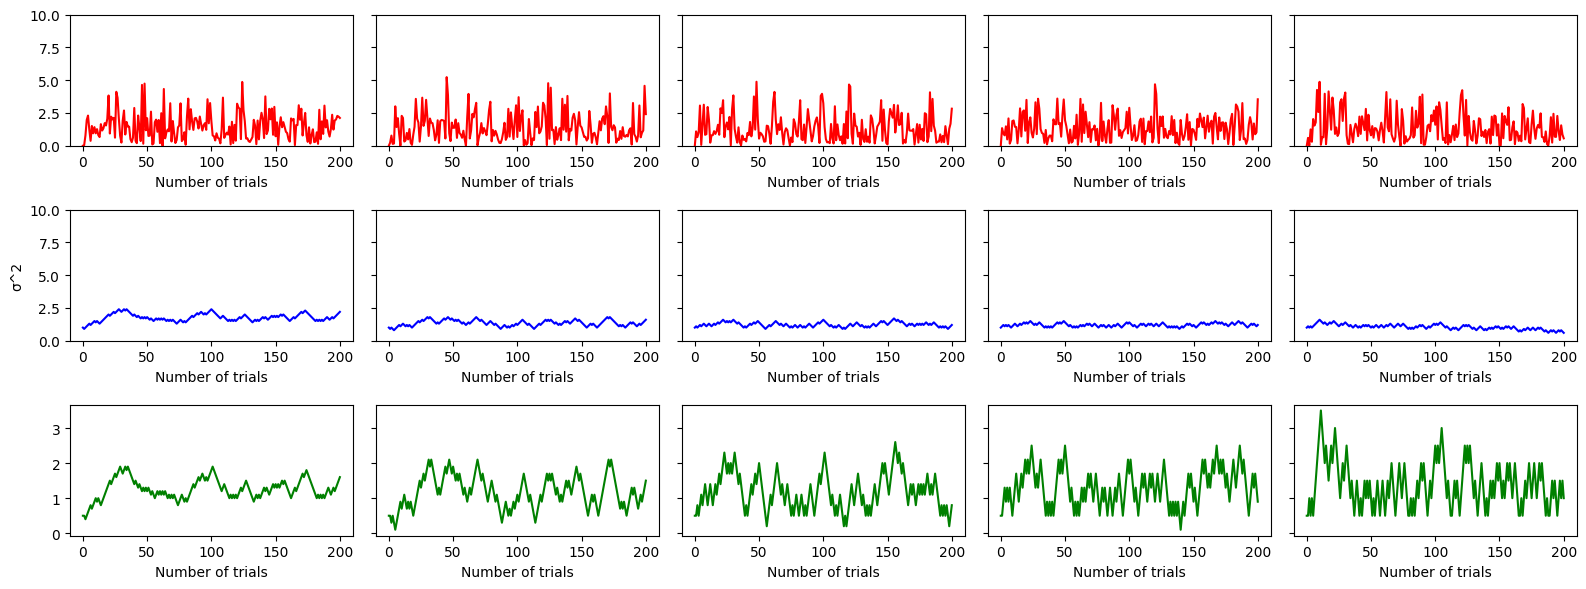

In [ ]:
for i in range(1,6):
  rt = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)

kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

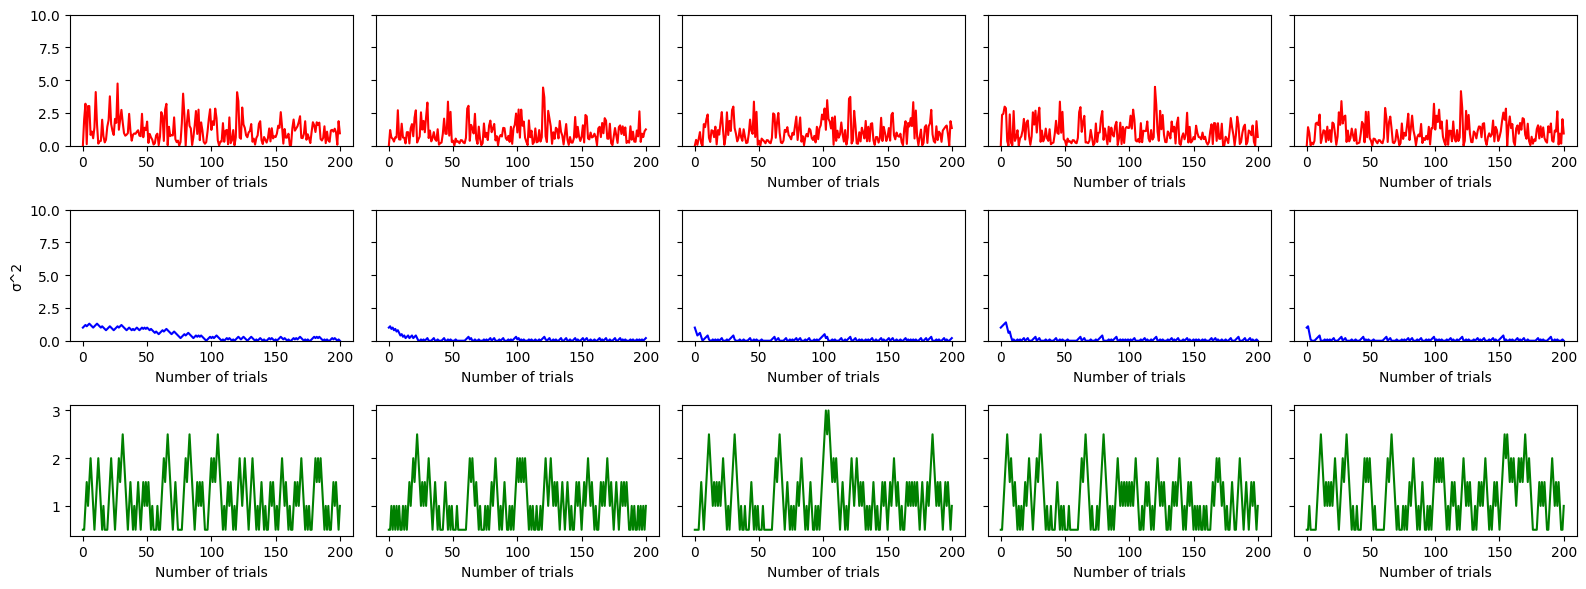

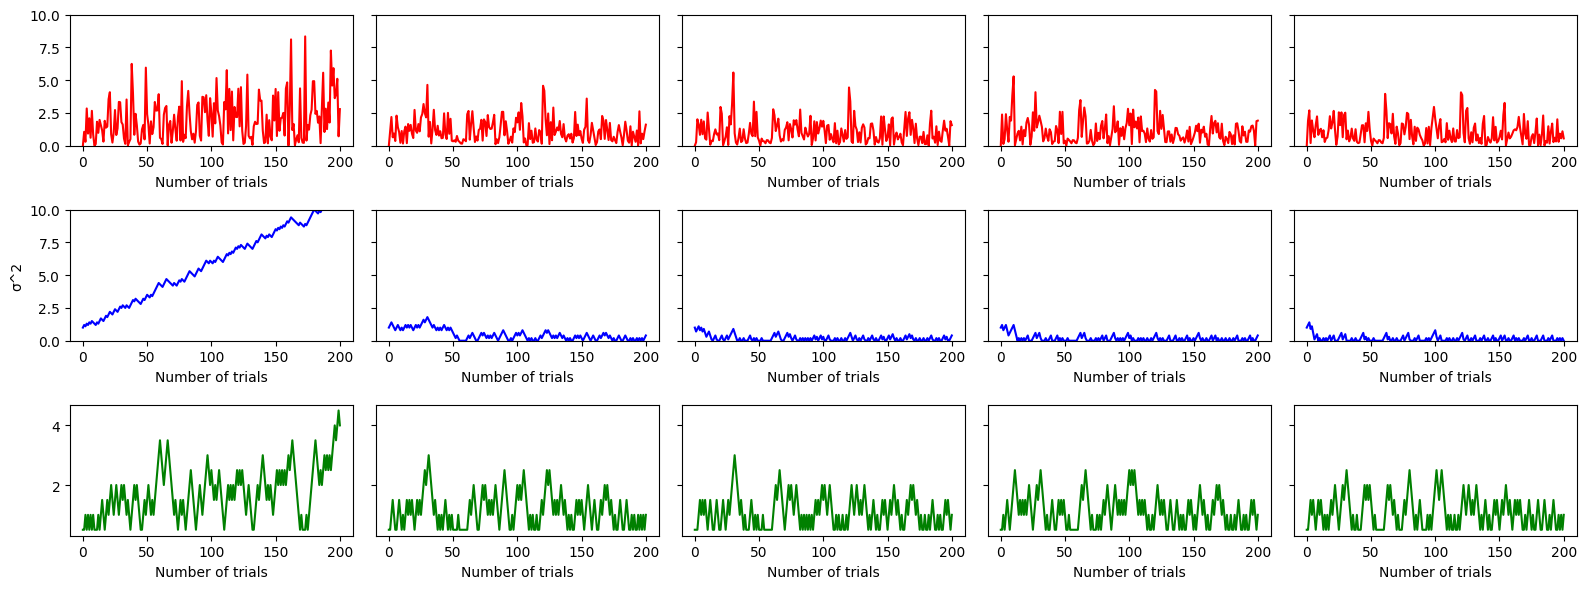

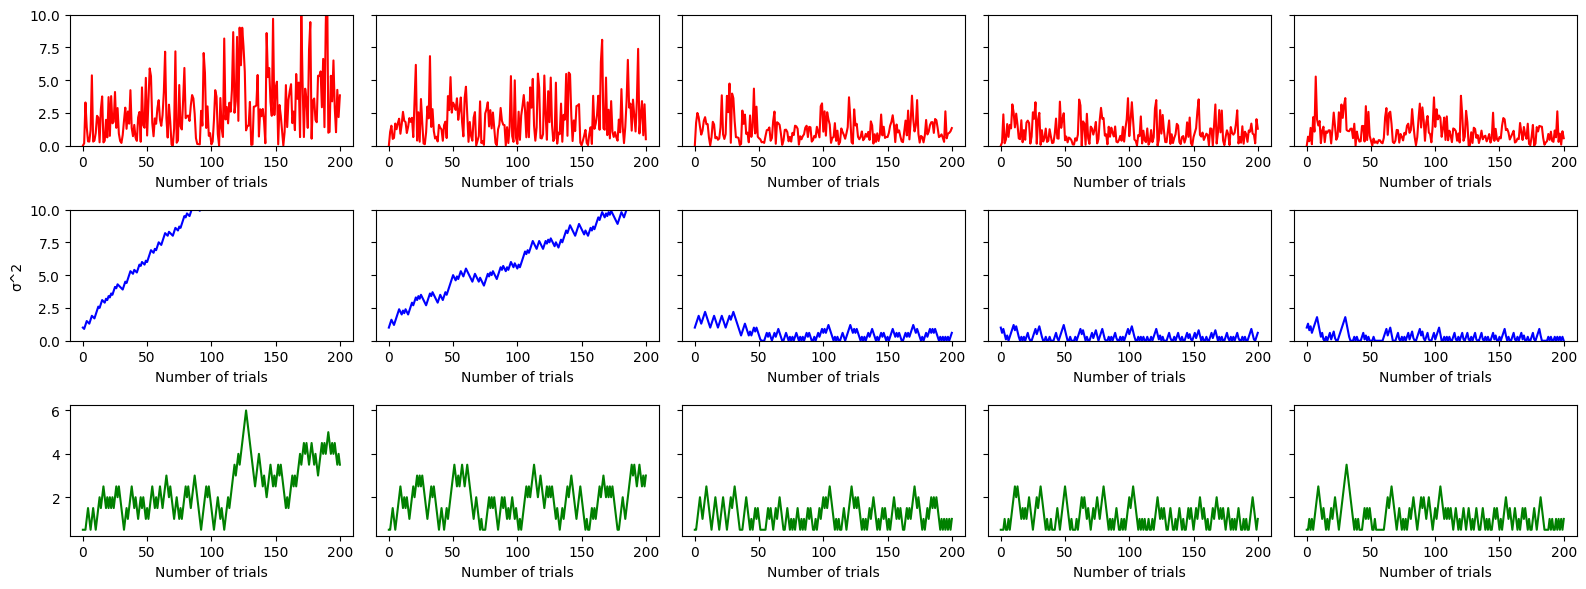

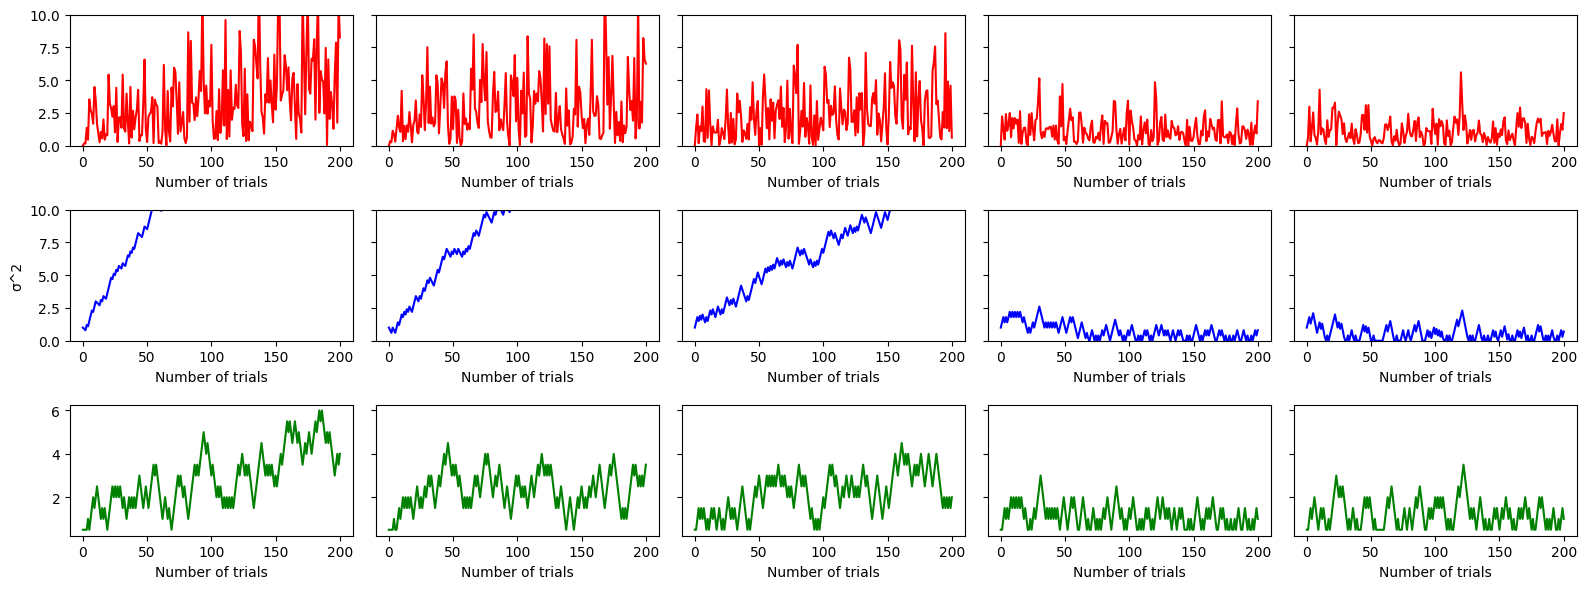

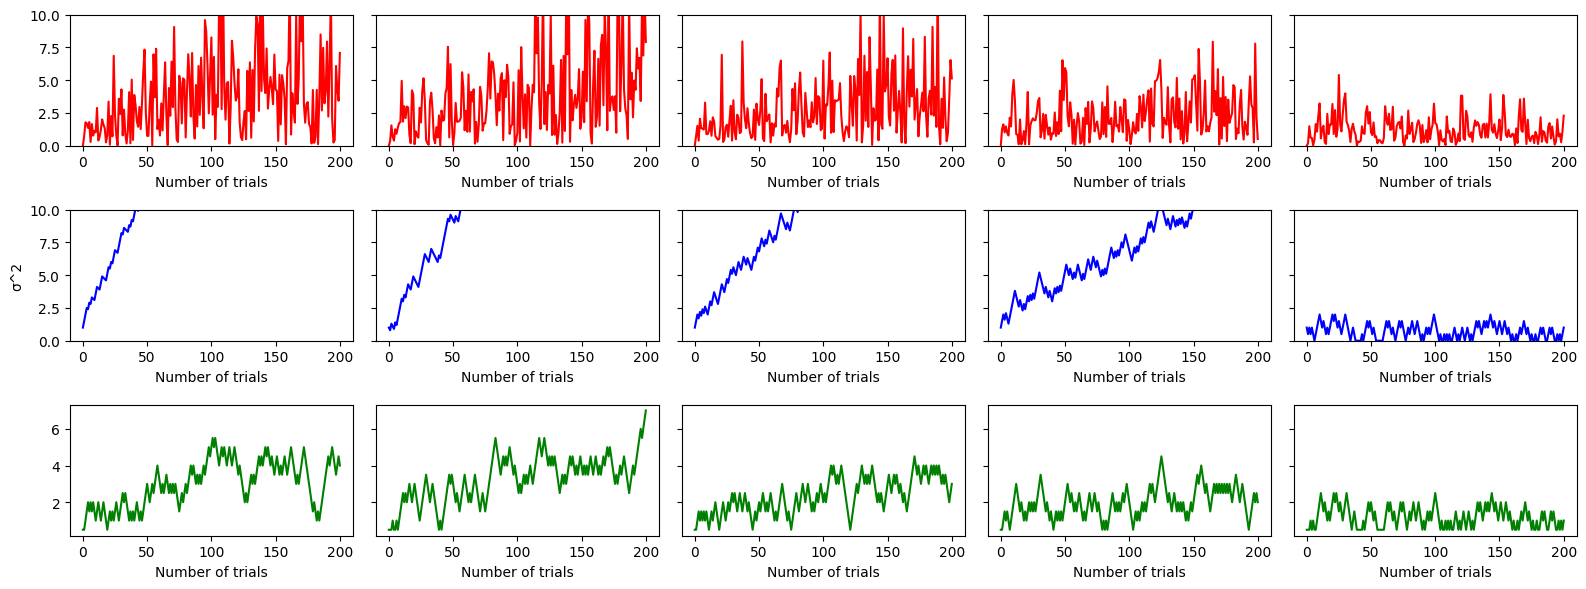

In [ ]:
for i in range(1,6):
  beta = i * 0.1
  for j in range(1,6):
    alpha = j * 0.1
    kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
  kendama_change.show_ajustment_from_min_average()

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

In [ ]:
alpha = 0.1       #成功した場合のやる気の変化量を表す変数
beta = 0.1    #失敗した場合のやる気の変化量を表す変数
a = 1  # どれだけの割合皿の中心を落下地点に移動させるかを表す変数（a=1なら落下地点に移動）
ganma = 0.5
trial_times = 1
get_times = 200
success_rate = 0.6 #難易度調整を行う際の成功率の指標
fail_rate = 0.6 #難易度調整を行う際の失敗率の指標

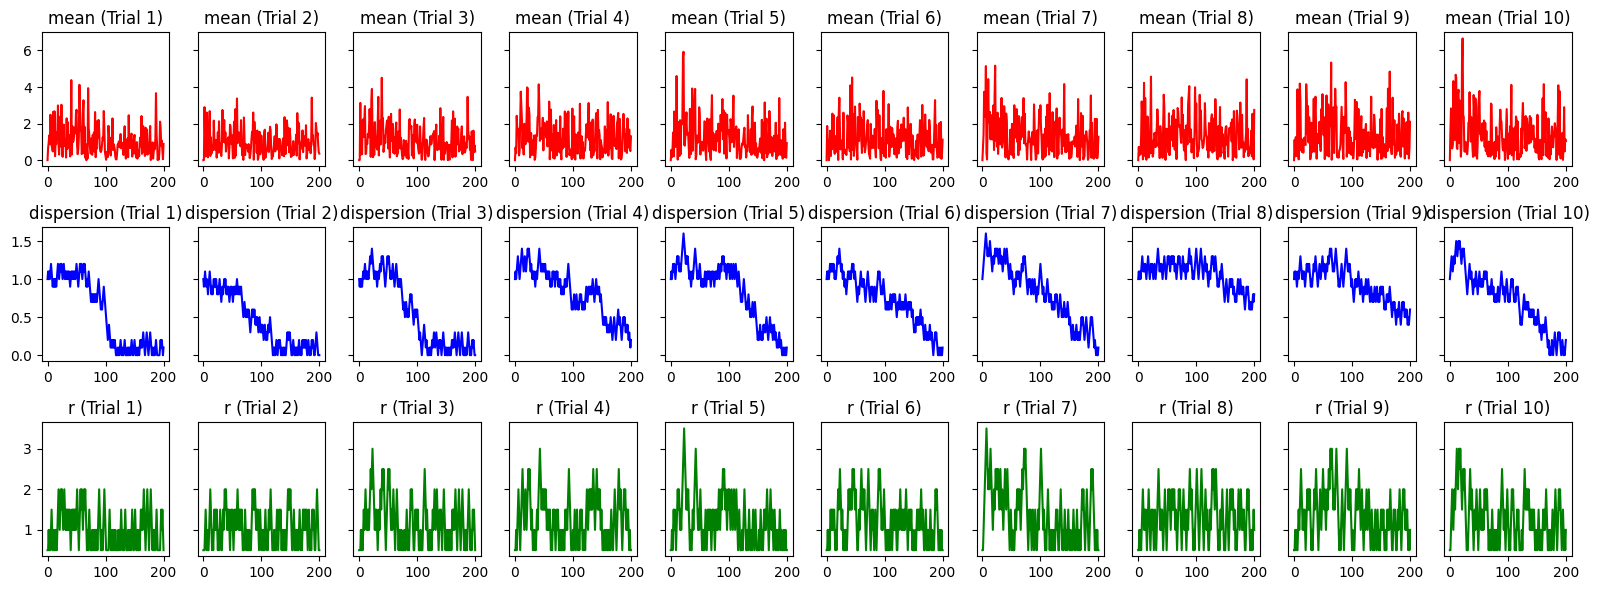

In [ ]:
for i in range(1,11):
  a = i * 0.1
  kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

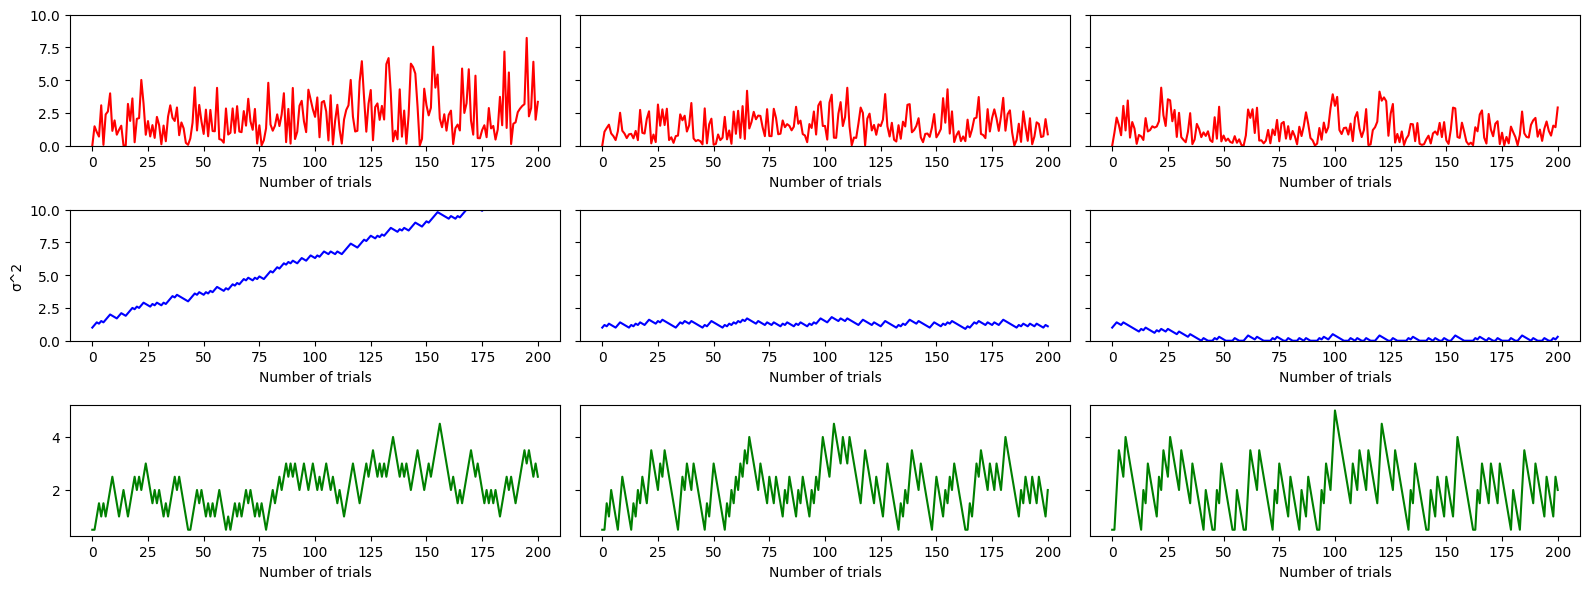

In [ ]:
beta = 0.2
alpha = 0.1
ganma = 0.5

kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.make_ajustment_from_min_average(0.5, trial_times, ganma, alpha, beta, a, success_rate, fail_rate)
kendama_change.show_ajustment_from_min_average()

In [ ]:
kendama_change.show_all("trial_times = 1")